In [1]:
import matplotlib.pyplot as plot
import numpy as np
from numba import njit, jit
import matplotlib.pyplot as plt

## 시뮬레이션과 OA ansatz를 비교

In [10]:
@jit(nopython=True)
def RK4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n,len(y0)))
    y[0] = y0

    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y
args = ()
@jit(nopython=True)
def H_Chimera(u,t=0,args = args):
    r1 = u[0]
    r2 = u[1]
    phi = u[2]
    beta,alpha,eta1,eta2 = args
    dr1 = 1/2 * r1* (1-r1**2)*(eta1**2 * r1**2 * np.cos(alpha) + 2 * beta*eta1*eta2*r1*r2*np.cos(alpha+phi) + beta**2 * eta2**2 * r2**2 * np.cos(alpha + 2*phi))
    dr2 = 1/2 * r2* (1-r2**2)*(eta2**2 * r2**2 * np.cos(alpha) + 2 * beta*eta1*eta2*r2*r1*np.cos(alpha-phi) + beta**2 * eta1**2 * r1**2 * np.cos(alpha - 2*phi))
    dpsi1 = -1/2 * (1+r1**2)*(eta1**2 * r1**2 * np.sin(alpha) + 2 * beta*eta1*eta2*r1*r2*np.sin(alpha+phi) + beta**2 * eta2**2 * r2**2 * np.sin(alpha + 2*phi))
    dpsi2 = -1/2 * (1+r2**2)*(eta2**2 * r2**2 * np.sin(alpha) + 2 * beta*eta1*eta2*r2*r1*np.sin(alpha-phi) + beta**2 * eta1**2 * r1**2 * np.sin(alpha - 2*phi))
    dphi = dpsi1 - dpsi2
    return np.array([dr1,dr2,dphi])


@jit(nopython=True)
def myFun2(u,t=0,args = args):
    r = u[0]
    phi = u[1]
    beta,alpha,eta1,eta2 = args
    dr = 1/2 * r* (1-r**2)*(eta2**2 * r**2 * np.cos(alpha) + 2 * beta*eta1*eta2*r*np.cos(alpha+phi) + beta**2 * eta1**2 * np.cos(alpha + 2*phi))
    dpsi2 = -1/2 * (1+r**2)*(eta2**2 * r**2 * np.sin(alpha) + 2 * beta*eta1*eta2*r*np.sin(alpha+phi) + beta**2 * eta1**2 * np.sin(alpha + 2*phi))
    dpsi1 = -1/2 * (2)*(eta1**2 * np.sin(alpha) + 2 * beta*eta1*eta2*r *np.sin(alpha-phi) + beta**2 * eta2**2 * r**2 * np.sin(alpha-2*phi))
    dphi =  dpsi2 - dpsi1
    return np.array([dr,dphi])


In [11]:
@jit(nopython=True)
def dZ_dt(Zs,t,alpha,beta,eta1,eta2):
    a1real,a1imag,b1real,b1imag,a2real,a2imag,b2real,b2imag = Zs
    a1 = a1real + 1j*a1imag
    a2 = a2real + 1j*a2imag
    b1 = b1real + 1j*b1imag
    b2 = b2real + 1j*b2imag
    Z11 = 1/2 * (np.conj(a1)+np.conj(b1)) + eta1/2 * (np.conj(a1)-np.conj(b1))
    Z12 = 1/2 * (np.conj(a2)+np.conj(b2)) + eta2/2 * (np.conj(a2)-np.conj(b2))
    H1 = Z11**2 + 2*beta*Z11*Z12 + beta**2*Z12**2
    H2 = Z12**2 + 2*beta*Z11*Z12 + beta**2*Z11**2
    
    da1 = 1/2 *(np.conj(H1)*np.conj(a1)*np.exp(1j*alpha) - H1*a1**3*np.exp(-1j*alpha) )
    db1 = 1/2 *(np.conj(H1)*np.conj(b1)*np.exp(1j*alpha) - H1*b1**3*np.exp(-1j*alpha) )
    da2 = 1/2 *(np.conj(H2)*np.conj(a2)*np.exp(1j*alpha) - H2*a2**3*np.exp(-1j*alpha) )
    db2 = 1/2 *(np.conj(H2)*np.conj(b2)*np.exp(1j*alpha) - H2*b2**3*np.exp(-1j*alpha) )
    return np.array([da1.real,da1.imag,db1.real,db1.imag,da2.real,da2.imag,db2.real,db2.imag])


def to_complex(Zs):
    a1real,a1imag,b1real,b1imag,a2real,a2imag,b2real,b2imag = Zs.T
    a1 = a1real + 1j*a1imag
    a2 = a2real + 1j*a2imag
    b1 = b1real + 1j*b1imag
    b2 = b2real + 1j*b2imag
    return a1,b1,a2,b2

In [12]:
import functools
import numpy as np
from scipy.optimize import root_scalar


def _vectorize_float(f):
    vectorized = np.vectorize(f, otypes=[float], signature="(),()->()")

    @functools.wraps(f)
    def wrapper(*args):
        return vectorized(*args)

    return wrapper


class MixtureDistribution:
    def __init__(self, distributions, weights):
        self._distributions = list(distributions)
        self._weights = list(weights)

        if not (all(w >= 0 for w in self._weights) and sum(self._weights) == 1):
            raise ValueError("Invalid weight vector.")

        if len(self._distributions) != len(self._weights):
            raise ValueError("Mixtures and weights must have the same length.")

        if len(self._distributions) < 2:
            raise ValueError("Must have at least two component distributions.")

    @_vectorize_float
    def pdf(self, x):
        return sum(w * d.pdf(x) for w, d in zip(self._weights, self._distributions))

    @_vectorize_float
    def cdf(self, x):
        return sum(w * d.cdf(x) for w, d in zip(self._weights, self._distributions))

    @_vectorize_float
    def ppf(self, p):
        bracket = [min(dist.ppf(p) for dist in self._distributions),
                   max(dist.ppf(p) for dist in self._distributions)]

        r = root_scalar(
            f=lambda x: self.cdf(x) - p,
            fprime=self.pdf,
            bracket=bracket,
            x0=0
        )
        assert r.converged
        return r.root
    # https://www.jamesatkins.com/posts/quantile-function-of-mixture-distributions-in-python/

In [13]:

@jit(nopython=True)
def RK4_ZZ(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    Etheta = np.exp(1j*y0)
    Na = args[0]
    EA,EB = Etheta[:Na],Etheta[Na:]
    Z1a,Z2a = get_ZE12(EA)
    Z1b,Z2b = get_ZE12(EB)
    Z1as = np.zeros(n,dtype=np.complex64)
    Z1bs = np.zeros(n,dtype=np.complex64)
    Z2as = np.zeros(n,dtype=np.complex64)
    Z2bs = np.zeros(n,dtype=np.complex64)

    Z1as[0] = Z1a
    Z2as[0] = Z2a
    Z1bs[0] = Z1b
    Z2bs[0] = Z2b
    
    y[0] = y0
    
    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1,Z1a,Z1b,Z2a,Z2b = f(y[i], t[i], *args)
        k2,_,_,_,_ = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3,_,_,_,_ = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4,_,_,_,_ = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        Z1as[i+1],Z1bs[i+1],Z2as[i+1],Z2bs[i+1] = Z1a,Z1b,Z2a,Z2b
    return y,(Z1as,Z1bs,Z2as,Z2bs)

@jit(nopython=True)
def RK4_ZZ2(f, y0, t, args=()):
    n = len(t)
    Etheta = np.exp(1j*y0)
    Na = args[0]
    EA,EB = Etheta[:Na],Etheta[Na:]
    Z1a,Z2a = get_ZE12(EA)
    Z1b,Z2b = get_ZE12(EB)
    Z1as = np.zeros(n,dtype=np.complex64)
    Z1bs = np.zeros(n,dtype=np.complex64)
    Z2as = np.zeros(n,dtype=np.complex64)
    Z2bs = np.zeros(n,dtype=np.complex64)

    Z1as[0] = Z1a
    Z2as[0] = Z2a
    Z1bs[0] = Z1b
    Z2bs[0] = Z2b
    
    y = y0
    
    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1,Z1a,Z1b,Z2a,Z2b = f(y, t[i], *args)
        k2,_,_,_,_ = f(y + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3,_,_,_,_ = f(y + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4,_,_,_,_ = f(y + k3 * h, t[i] + h, *args)
        y = y + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        Z1as[i+1],Z1bs[i+1],Z2as[i+1],Z2bs[i+1] = Z1a,Z1b,Z2a,Z2b
    return Z1as,Z1bs,Z2as,Z2bs

@jit(nopython=True)
def get_ZE12(Etheta):
    ''' get theta and return r and theta'''
    E1 = Etheta
    E2 = E1**2
    Z1,Z2 = np.mean(E1),np.mean(E2)
    return Z1,Z2

# @jit(nopython=True)
# def Kuramoto_MF_CHIMERA(Theta,t,Na,Nb,beta,alpha,K):
#     dtheta = np.zeros(Na+Nb)

#     Etheta = np.exp(1j*Theta)
#     EA,EB = Etheta[:Na],Etheta`[Na:]
#     Z1a,Z2a = get_ZE12(EA)
#     Z1b,Z2b = get_ZE12(EB)
#     A = np.exp(-1j*alpha)
#     EA,EB = np.conjugate(EA), np.conjugate(EB)
#     ZZa =  (Z1a+beta*Z1b)
#     ZZb =  (Z1b+beta*Z1a)
#     dtheta[:Na] = K*((A*(ZZa**2-Z2a/Na - beta*Z2b/Nb))*EA*EA -(2*A/Na*ZZa)*EA).imag
#     dtheta[Na:] = K*((A*(ZZb**2-Z2b/Nb - beta*Z2a/Na))*EB*EB -(2*A/Nb*ZZb)*EB).imag
#     return dtheta,Z1a,Z1b,Z2a,Z2b

@jit(nopython=True)
def Kuramoto_MF_CHIMERA(Theta,t,Na,Nb,beta,alpha,K):
    dtheta = np.zeros(Na+Nb)

    Etheta = np.exp(1j*Theta)
    EA,EB = Etheta[:Na],Etheta[Na:]
    Z1a,Z2a = get_ZE12(EA)
    Z1b,Z2b = get_ZE12(EB)
    A = np.exp(-1j*alpha)
    EA,EB = np.conjugate(EA), np.conjugate(EB)
    ZZa =  K*(Z1a+beta*Z1b)
    ZZb =  K*(Z1b+beta*Z1a)
    dtheta[:Na] = ((A*(ZZa**2))*EA*EA).imag
    dtheta[Na:] = ((A*(ZZb**2))*EB*EB).imag
    return dtheta,Z1a,Z1b,Z2a,Z2b

In [107]:
alpha = 0.1
beta = 0.2
eta1 = 0.2
eta2 = 0.1

args = beta,alpha,eta1,eta2

In [108]:
t = np.arange(0,2000,0.1)

In [109]:
u0 =  [np.sqrt(0.6),0]
R1,P1 = RK4(myFun2,np.array(u0),t,args=(args,)).T
u0 =  [1,np.sqrt(0.6),0]
_,R2,P2 = RK4(H_Chimera,np.array(u0),t,args=(args,)).T

In [110]:
A1 = 1
A2 = np.sqrt(0.6)
shift = 0.0 * np.pi

a1 =  A1 *np.exp(0j)
b1 =  a1 * np.exp(np.pi*1j)
a2 =  A2*np.exp(shift*1.0j)
b2 =  a2* np.exp(np.pi*1j)

Zs = RK4(dZ_dt,np.array([a1.real,a1.imag,b1.real,b1.imag,a2.real,a2.imag,b2.real,b2.imag]),t,args=(alpha,beta,eta1,eta2))
a1s,b1s,a2s,b2s = to_complex(Zs)

RZ1 = 1/2 * (np.conj(a1s)+np.conj(b1s)) + eta1/2 * (np.conj(a1s)-np.conj(b1s))
QZ1 = 1/2 * (np.conj(a1s)**2+np.conj(b1s)**2) + eta1/2 * (np.conj(a1s)**2-np.conj(b1s)**2)
RZ2 = 1/2 * (np.conj(a2s)+np.conj(b2s)) + eta2/2 * (np.conj(a2s)-np.conj(b2s))
QZ2 = 1/2 * (np.conj(a2s)**2+np.conj(b2s)**2) + eta2/2 * (np.conj(a2s)**2-np.conj(b2s)**2)

R1s = np.abs(RZ1)
R2s = np.abs(RZ2)
Q1s = np.abs(QZ1)
Q2s = np.abs(QZ2)

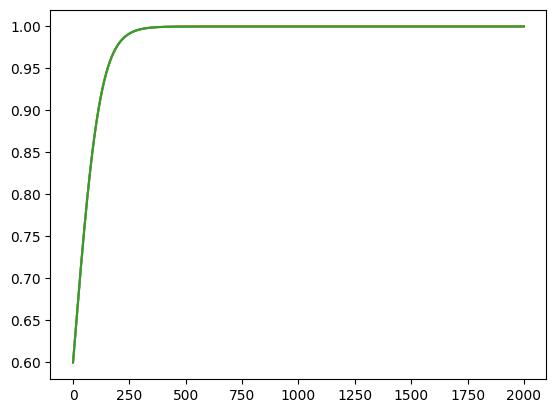

In [111]:
plt.plot(t,R1**2)
plt.plot(t,R2**2)
plt.plot(t,Q2s)

In [112]:
from scipy import stats

In [117]:
eta1 = 0.1
eta2 = 0.05
sigma1 = 1e-10
sigma2 = 0.50790452
shift = 0*np.pi/8


m1 = MixtureDistribution([stats.norm(0,sigma1), stats.norm(np.pi,sigma1)], [1/2 + eta1/2, 1/2 - eta1/2])
m2 = MixtureDistribution([stats.norm(0+shift,sigma2), stats.norm(np.pi+shift,sigma2)], [1/2 + eta2/2, 1/2 - eta2/2])

N = 1000
ps = (np.arange(N+1)[:-1] + 1)/(N+1)
theta1 = m1.ppf(ps)
theta2 = m2.ppf(ps)
Theta = np.r_[theta1,theta2]

Q2_init = np.mean(np.exp(2j*theta2))
print(abs(Q2_init),np.angle(Q2_init))

0.5984726638394532 -2.1827659711347538e-05


In [64]:
Q2_S = {}

In [118]:
N1 = N2 = N
K = 1
(Z1as,Z1bs,Z2as,Z2bs) = RK4_ZZ2(Kuramoto_MF_CHIMERA,Theta.copy(),t,args=(N1,N2,beta,alpha,K))
R1_S = np.abs(Z1as)
R2_S = np.abs(Z1bs)
Q1_S = np.abs(Z2as)
Q2_S = np.abs(Z2bs)

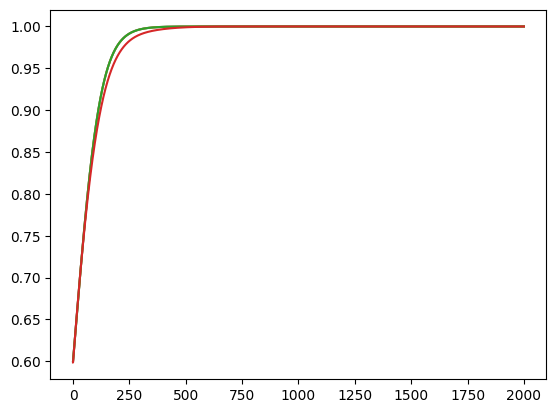

In [119]:
plt.plot(t,R1**2)
plt.plot(t,R2**2)
plt.plot(t,Q2s)
plt.plot(t,Q2_S)

# for N in [500,1000,2000,5000,10000]:
    # plt.plot(t,Q2_S[N])
# plt.loglog()

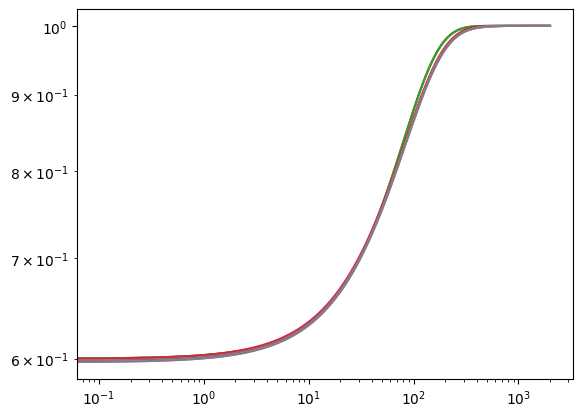

In [103]:
plt.plot(t,R1**2)
plt.plot(t,R2**2)
plt.plot(t,Q2s)
plt.loglog()

for N in [500,1000,2000,5000,10000]:
    plt.plot(t,Q2_S[N])
# plt.plot(t,Q2_S)

Text(0, 0.5, 'y')

<Figure size 3200x2400 with 0 Axes>

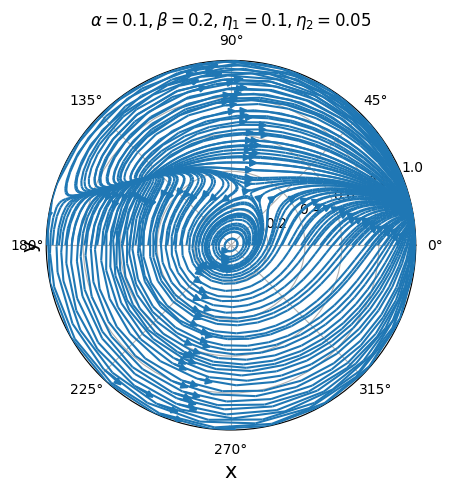

In [84]:
# beta = 0.7
# alpha = 1.2
# eta1 = 0.1
# eta2 = 0.05

alpha = 0.1
beta = 0.2
eta1 = 0.1
eta2 = 0.05

args = beta,alpha,eta1,eta2
t = np.arange(0,6000,0.1)
# y = np.linspace(0,0,1)
# x = np.linspace(0,2*np.pi,5)
# X,Y = np.meshgrid(x,y)
# fx = 0.5
# fy = 0.5


# u0s = [[1-1e-3,0],[0 + 1e-3,1],[fx,fy]]
# u0s = [[1,0.5],[0,0],[0.2,0],[0.3,0],[0.6, 0],[0.9114966199929684-0.1,3.072208206306462+0.1]]
# u0s = [[x_,y_] for x_,y_ in zip(X.flatten(),Y.flatten()) ]
plt.figure(dpi=500)


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.sca(ax)
# for i,u0 in enumerate(u0s):

# 	u = RK4(myFun2,np.array(u0,dtype=float),t,args=(args,))
# 	if i == 3:
# 		c = plt.scatter(u[0,0],u[0,1]%(np.pi*2),s=50,label=r'$\vec{x}^*(0)=(%.1f,%.1f)$'%(u0[0],u0[1]))
# 	else:	
# 		c = plt.scatter(u[0,0],u[0,1]%(np.pi*2),s=50,label=r'$\vec{x}(0)=(%.1f,%.1f)$'%(u0[0],u0[1]))
# 	plt.scatter(u[-1,0],u[-1,1]%(np.pi*2),s=50,marker='s',zorder=7,color=c.get_facecolor())
# 	plt.scatter(u[:,0],u[:,1]%(np.pi*2),s=1,alpha=0.8,zorder=6,color=c.get_facecolor())#,label=r'$\vec{x}(0)=(%.1f,%.1f)$'%(u0[0],u0[1]))

# plt.legend()
x = np.linspace(0.0,1,500)
y = np.linspace(0,3.*np.pi,500)
X,Y = np.meshgrid(x,y)

U,V = myFun2([X,Y],0,args)
M = (np.hypot(U,V))
# U = U / np.sqrt(U**2 + V**2);
# V = V / np.sqrt(U**2 + V**2);

# V = 0*V
xs = np.linspace(-3,-1e-5,1000)
# U = U / np.sqrt(U**2 + V**2);
# V = V / np.sqrt(U**2 + V**2);

# plt.axhline(0,color='black')
# plt.plot(xs,-np.log(-xs),color='black')
# plt.plot(x,xdot(x,y)
# Q = plt.quiver(y,x,V,U,M,scale=20,pivot='mid',cmap='jet',zorder=3,alpha=0.7)

# plt.colorbar()
plt.ylim(0,1.0)
plt.xlim(0,2*np.pi)
# plt.legend()

ax.streamplot(Y.T,X.T,V.T,U.T,zorder=3,cmap='magma',broken_streamlines=False)
ax.axhline(1,color='RED')

xs = np.linspace(-10,10,1000)
# plt.plot(xs,F(xs))
ax.grid(True)
ax.minorticks_on()
plt.title(rf'$\alpha={alpha},\beta={beta},\eta_1={eta1},\eta_2={eta2}$')
# plt.plot(-1,0,'o',ms=10,markeredgewidth=2,markerfacecolor='white')
plt.xlabel('x',fontsize=15)
plt.ylabel('y',fontsize=15)
# plt.legend()

# qk = plt.quiverkey(Q, 0.9, 0.9, 1, r'$2 \frac{m}{s}$', labelpos='E',
#                    coordinates='figure')



ValueError: The rows of 'x' must be equal

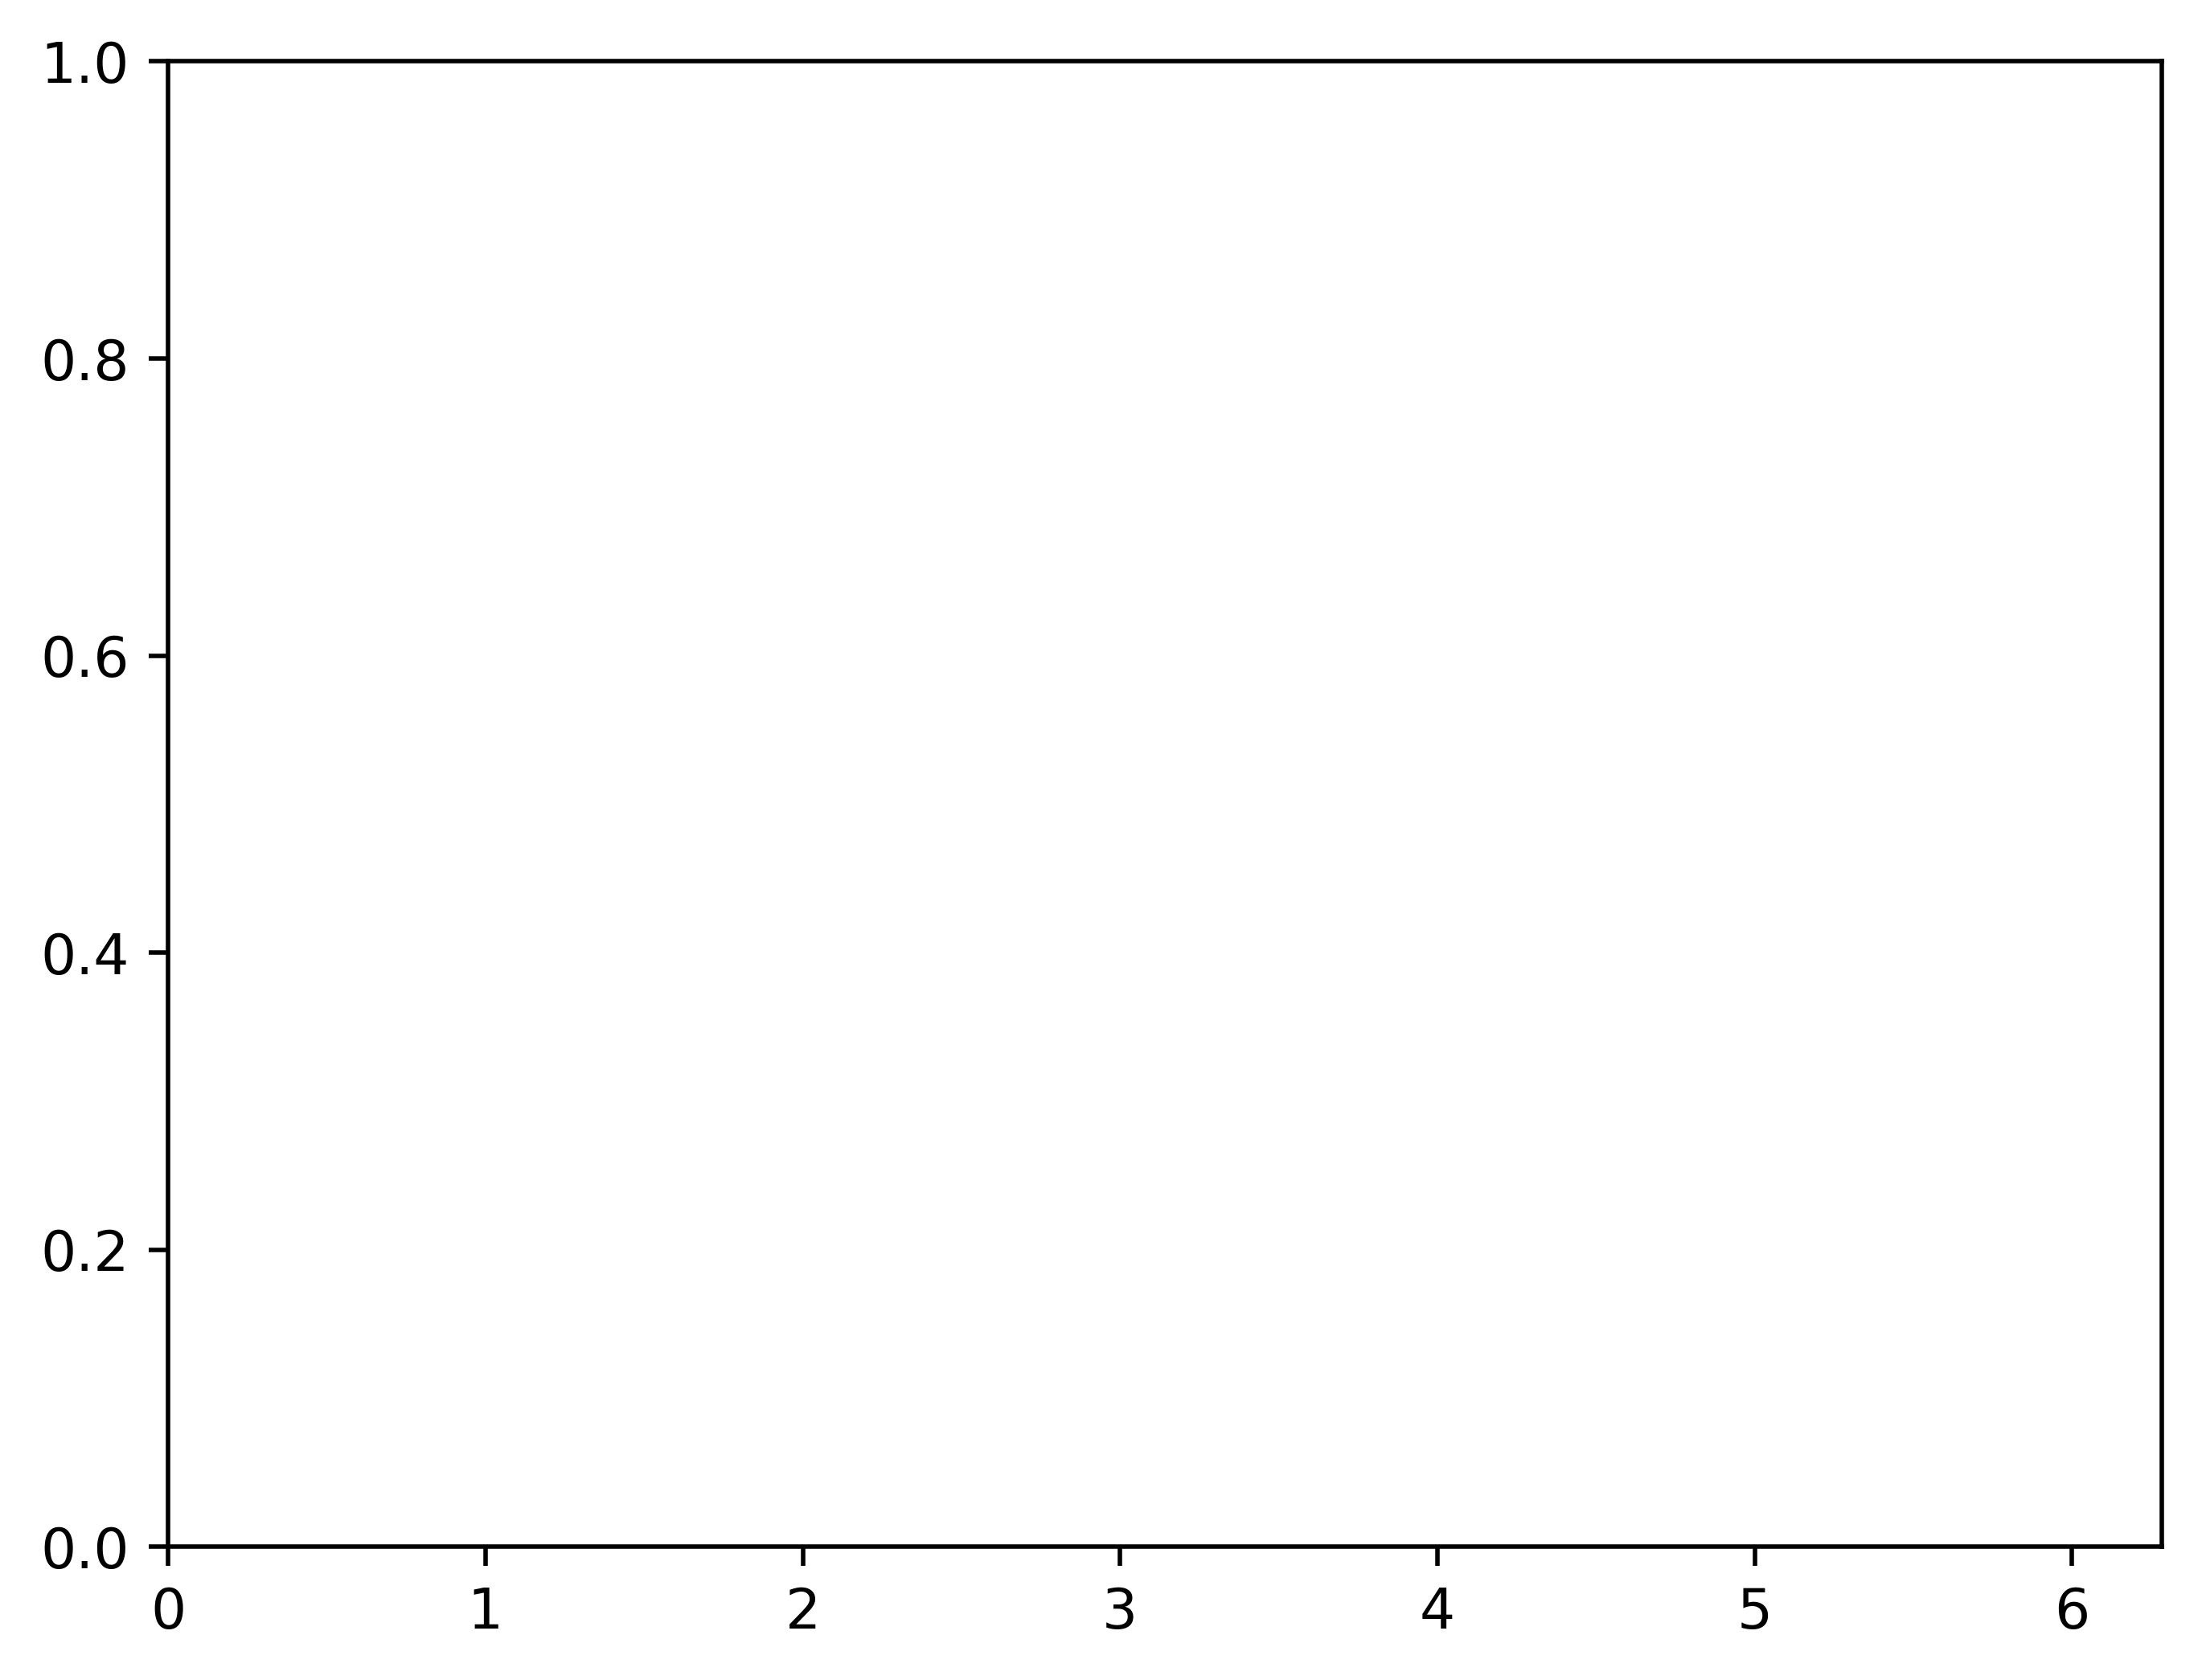

In [85]:
# beta = 0.7
# alpha = 1.2
# eta1 = 0.1
# eta2 = 0.05

alpha = 1.2
beta = 0.3
eta1 = 0.1
eta2 = 0.05

args = beta,alpha,eta1,eta2
t = np.arange(0,6000,0.1)
# y = np.linspace(0,0,1)
# x = np.linspace(0,2*np.pi,5)
# X,Y = np.meshgrid(x,y)
# fx = 0.5
# fy = 0.5


# u0s = [[1-1e-3,0],[0 + 1e-3,1],[fx,fy]]
# u0s = [[1,0.5],[0,0],[0.2,0],[0.3,0],[0.6, 0],[0.9114966199929684-0.1,3.072208206306462+0.1]]
# u0s = [[x_,y_] for x_,y_ in zip(X.flatten(),Y.flatten()) ]
plt.figure(dpi=500)


# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# plt.sca(ax)
# for i,u0 in enumerate(u0s):

# 	u = RK4(myFun2,np.array(u0,dtype=float),t,args=(args,))
# 	if i == 3:
# 		c = plt.scatter(u[0,0],u[0,1]%(np.pi*2),s=50,label=r'$\vec{x}^*(0)=(%.1f,%.1f)$'%(u0[0],u0[1]))
# 	else:	
# 		c = plt.scatter(u[0,0],u[0,1]%(np.pi*2),s=50,label=r'$\vec{x}(0)=(%.1f,%.1f)$'%(u0[0],u0[1]))
# 	plt.scatter(u[-1,0],u[-1,1]%(np.pi*2),s=50,marker='s',zorder=7,color=c.get_facecolor())
# 	plt.scatter(u[:,0],u[:,1]%(np.pi*2),s=1,alpha=0.8,zorder=6,color=c.get_facecolor())#,label=r'$\vec{x}(0)=(%.1f,%.1f)$'%(u0[0],u0[1]))

# plt.legend()
x = np.linspace(0.0,1,500)
y = np.linspace(0,3.*np.pi,500)
X,Y = np.meshgrid(x,y)

U,V = myFun2([X,Y],0,args)
M = (np.hypot(U,V))

XX = X*np.cos(Y)
YY = X*np.sin(Y)
# U = U / np.sqrt(U**2 + V**2);
# V = V / np.sqrt(U**2 + V**2);

# V = 0*V
xs = np.linspace(-3,-1e-5,1000)
# U = U / np.sqrt(U**2 + V**2);
# V = V / np.sqrt(U**2 + V**2);

# plt.axhline(0,color='black')
# plt.plot(xs,-np.log(-xs),color='black')
# plt.plot(x,xdot(x,y)
# Q = plt.quiver(y,x,V,U,M,scale=20,pivot='mid',cmap='jet',zorder=3,alpha=0.7)

# plt.colorbar()
plt.ylim(0,1.0)
plt.xlim(0,2*np.pi)
# plt.legend()

plt.streamplot(XX.T,YY.T,V.T,U.T,zorder=3,cmap='magma',broken_streamlines=False)
plt.axhline(1,color='RED')

xs = np.linspace(-10,10,1000)
# plt.plot(xs,F(xs))
ax.grid(True)
ax.minorticks_on()
plt.title(rf'$\alpha={alpha},\beta={beta},\eta_1={eta1},\eta_2={eta2}$')
# plt.plot(-1,0,'o',ms=10,markeredgewidth=2,markerfacecolor='white')
plt.xlabel('x',fontsize=15)
plt.ylabel('y',fontsize=15)
# plt.legend()

# qk = plt.quiverkey(Q, 0.9, 0.9, 1, r'$2 \frac{m}{s}$', labelpos='E',
#                    coordinates='figure')



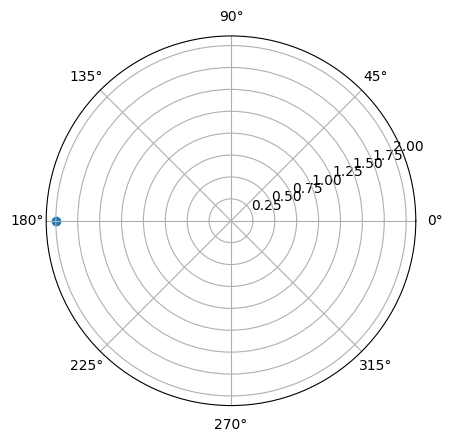

In [32]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.scatter(np.pi,2)